In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('ignore')

In [178]:
# import data
df= pd.read_csv('US_monthly_domestic_flights_passenger.csv', parse_dates=True)
df= df.set_index(pd.to_datetime(df['Date'])).drop('Date', axis=1)
df.head()

,Passenger
Date,
2002-10-01,48054917
2002-11-01,44850246
2002-12-01,49684353
2003-01-01,43032450
2003-02-01,41166780


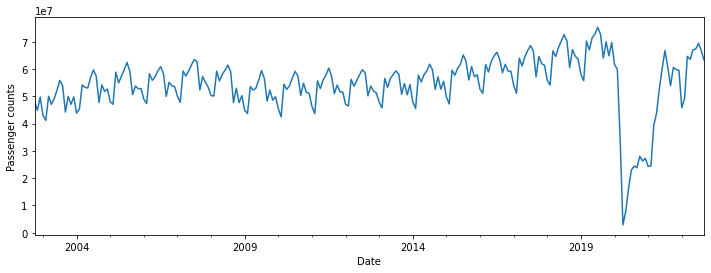

In [179]:
# plots time-series data
df['Passenger'].plot(figsize=(12,4))
plt.ylabel('Passenger counts'); plt.show()

## Defining normal and abnormal samples:
- **Normal class:** 12 months of data with normal behaviour - showing high and low seasons
- **Rare event:** Any 12 month sequence that doesn't follow a normal behaviour 

In [180]:
# create a dataframe containing only normal samples
normal_df= df.loc[df.index<'2016-12-01']

# a dataframe containing both normal and anomalous samples
test_df= df.loc[df.index>='2016-12-01']

In [181]:
# fit a scaler to training data and transform both training (normal) and test dataframes
sc=StandardScaler()
normal_df['Passenger_scaled']= sc.fit_transform(normal_df[['Passenger']])
test_df['Passenger_scaled']= sc.transform(test_df[['Passenger']])

### Input data preparation for LSTM
Input to LSTMs are 3-dimensional arrays with a shape of samples (number of sequences) x timesteps (window size) x features (number of features in the input data)
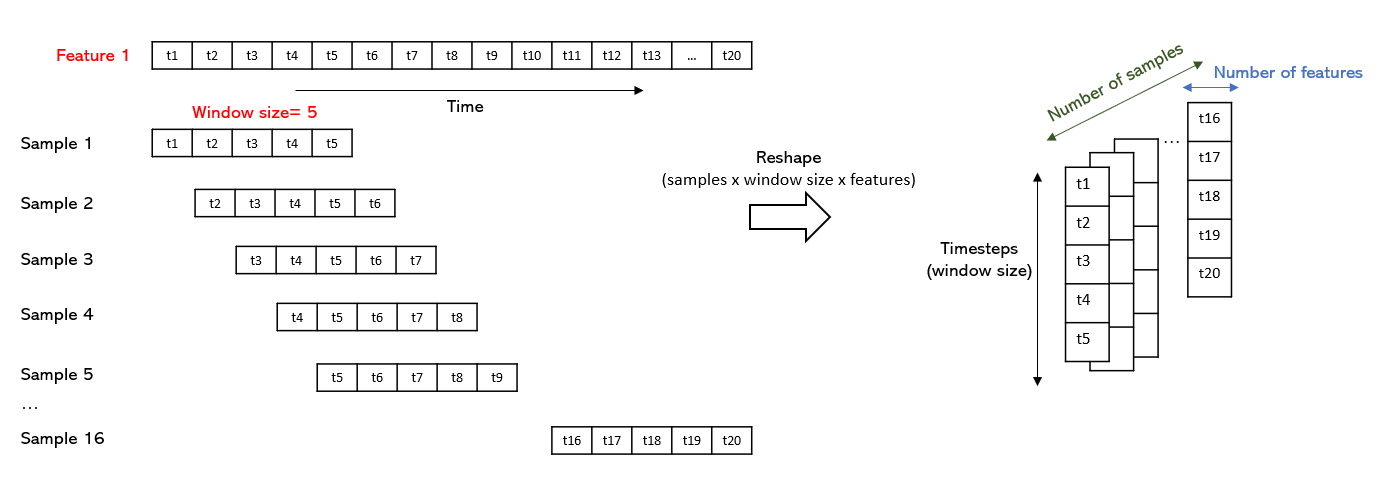

In [182]:
# Define function to create samples and reshape the result as required by keras
def input_generator(data,ws, n_feature):  # ws is the window size
    samples = []
    for i in range(len(data)-ws):
        seq = data[i:i+ws]
        samples.append((seq))
    arr= np.array(samples).reshape(-1, ws, n_feature)
    return arr

In [183]:
# generate datasets
train_arr= input_generator(normal_df['Passenger_scaled'], 12, 1)
test_arr = input_generator(test_df['Passenger_scaled'], 12, 1)

In [184]:
# check train dataset shape
train_arr.shape

(158, 12, 1)

In [8]:
import keras
from keras.models import Sequential
from keras.layers import LSTM, Dense, Dropout, RepeatVector, TimeDistributed

In [185]:
# build lstm-autoencoder
keras.backend.clear_session()
lstm_autoencoder = Sequential()
# Encoder - layer1: 64 lstm cells -- Layer2: 32 lstm cells
lstm_autoencoder.add(LSTM(64, activation='relu', input_shape=(12, 1), return_sequences=True))
#lstm_autoencoder.add(Dropout(0.4))
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=False))
lstm_autoencoder.add(RepeatVector(12))
# Decoder - - layer1: 32 lstm cells -- Layer2: 64 lstm cells
lstm_autoencoder.add(LSTM(32, activation='relu', return_sequences=True))
#lstm_autoencoder.add(Dropout(0.4))
lstm_autoencoder.add(LSTM(64, activation='relu', return_sequences=True))
lstm_autoencoder.add(TimeDistributed(Dense(1)))

In [186]:
# compile and fit the autoencoder to train dataset
lstm_autoencoder.compile(loss='mse',  optimizer=keras.optimizers.Adam(learning_rate=.001))

lstm_autoencoder_history = lstm_autoencoder.fit(train_arr, train_arr, epochs=120, batch_size=16, validation_split=.1, verbose=0)

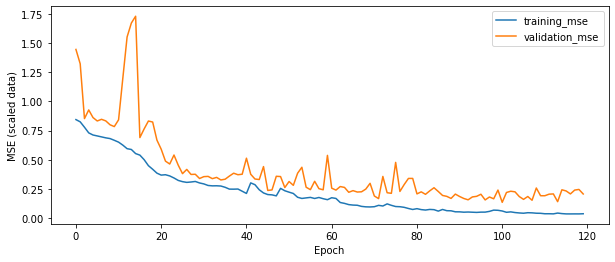

In [187]:
fig, axes= plt.subplots(1,1, figsize=(10,4))
axes.plot(lstm_autoencoder_history.history['loss'], label='training_mse')
axes.plot(lstm_autoencoder_history.history['val_loss'], label='validation_mse')
axes.set_xlabel('Epoch'); axes.set_ylabel('MSE (scaled data)')
axes.legend()
plt.show()

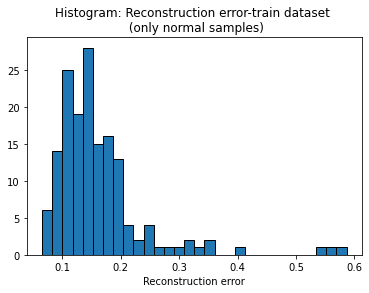

In [188]:
# predict (reconstruct) train data
train_predict= lstm_autoencoder.predict(train_arr, verbose=0)

# calculate the reconstruction error
train_reconstruct_error= np.mean(np.abs(train_arr - train_predict), axis=1)

plt.hist(train_reconstruct_error, bins=30, ec='black')
plt.title('Histogram: Reconstruction error-train dataset \n (only normal samples)')
plt.xlabel('Reconstruction error')
plt.show()

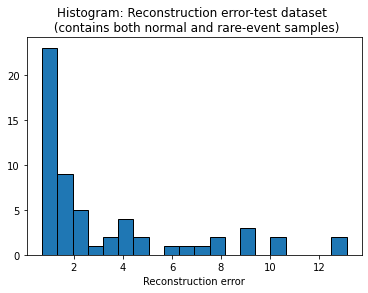

In [189]:
# predict (reconstruct) test data and calculate the reconstruction error
test_predict= lstm_autoencoder.predict(test_arr, verbose=0)

# calculate the reconstruction error
test_reconstruct_error= np.mean(np.abs(test_arr - test_predict), axis=1)

plt.hist(test_reconstruct_error, bins=20, ec='black')
plt.title('Histogram: Reconstruction error-test dataset \n (contains both normal and rare-event samples)')
plt.xlabel('Reconstruction error') 
plt.show()

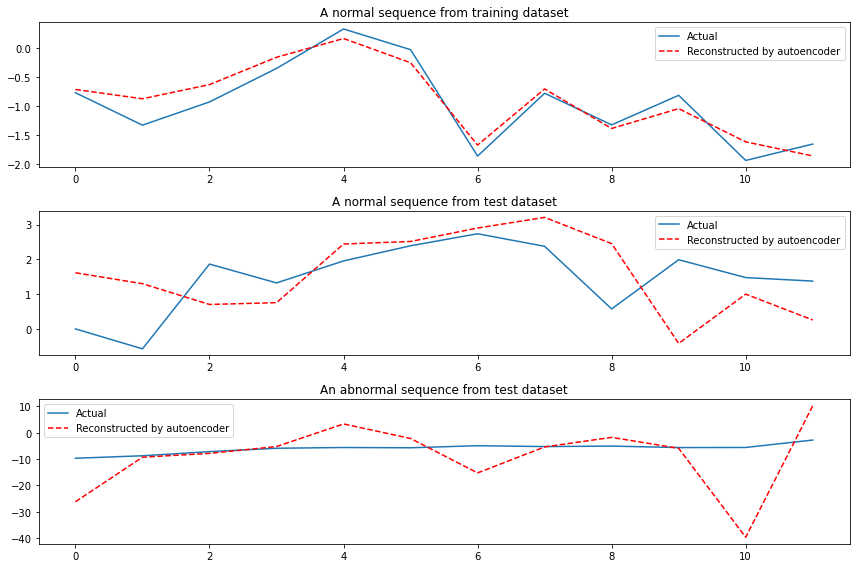

In [209]:
# create plots to evaluate to compare reconstructed and actual sequences
fig, axes= plt.subplots(3,1, figsize=(12,8))
axes[0].plot(train_arr[5,:,:], label='Actual')
axes[0].plot(train_predict[5,:,:], color='red', ls='--', label='Reconstructed by autoencoder')
axes[0].set_title('A normal sequence from training dataset')
axes[0].legend()

axes[1].plot(test_arr[1,:,:], label='Actual')
axes[1].plot(test_predict[1,:,:], color='red', ls='--', label='Reconstructed by autoencoder')
axes[1].set_title('A normal sequence from test dataset')
axes[1].legend()

axes[2].plot(test_arr[40,:,:], label='Actual')
axes[2].plot(test_predict[40,:,:], color='red', ls='--', label='Reconstructed by autoencoder')
axes[2].set_title('An abnormal sequence from test dataset')
axes[2].legend()

plt.tight_layout()
plt.show()

In [202]:
# add a new column to df to assign reconstruction error of each sequence to its first point (for plotting)
df['err']= list(train_reconstruct_error.flatten())+[np.nan]*12 + list (test_reconstruct_error.flatten())+[np.nan]*12

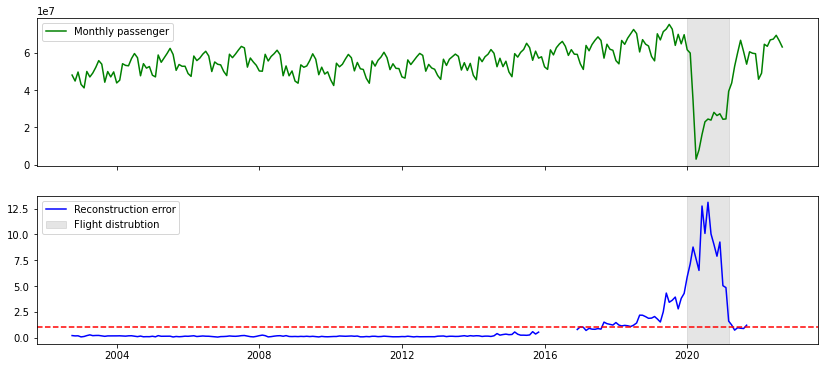

In [220]:
# plot monthly passenger data and calculated error

fig, ax = plt.subplots(2,1, figsize=(14, 6), sharex=True)

ax[0].plot(df[['Passenger']], 'g-', label='Monthly passenger')
ax[0].axvspan('2020-01', '2021-03', alpha=0.2, color='grey', label='Flight distrubtion')
ax[1].plot(df[['err']], 'b-', label='Reconstruction error')
ax[1].axvspan('2020-01-03', '2021-03', alpha=0.2, color='grey', label='High reconstructi')
ax[1].axhline(1,ls='--', color='red')
ax[0].legend(); ax[1].legend()
plt.show()